In [1]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [2]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [3]:
# import data (btc/usdt downloaded from cryptodowloand)
df = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
df.head(5)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1619742900000,2021-04-30 00:35:00,BTC/USDT,53580.98,53604.23,53518.93,53529.89,35.290715,1.890619e+06,996
1,1619742840000,2021-04-30 00:34:00,BTC/USDT,53677.39,53722.40,53564.00,53580.98,89.941874,4.823830e+06,1777
2,1619742780000,2021-04-30 00:33:00,BTC/USDT,53674.53,53691.13,53615.98,53677.39,81.940577,4.396348e+06,1621
3,1619742720000,2021-04-30 00:32:00,BTC/USDT,53780.39,53784.04,53674.52,53674.53,53.895245,2.895554e+06,1595
4,1619742660000,2021-04-30 00:31:00,BTC/USDT,53745.99,53816.36,53700.00,53780.39,169.848725,9.132947e+06,2568


In [4]:
# Dataset manipulation to prepare data
df = df.rename(columns={'Volume USDT': 'volume'})
df = df.iloc[::-1]
df.columns
df = df.drop(columns=['symbol', 'Volume BTC'])
df.head(5)

,unix,date,open,high,low,close,volume,tradecount
330482,1599856800000,2020-09-11 20:40:00,10317.00,10317.01,10314.36,10316.00,340398.477553,342
330481,1599856860000,2020-09-11 20:41:00,10316.00,10321.09,10316.00,10319.50,168497.705251,256
330480,1599856920000,2020-09-11 20:42:00,10319.50,10320.31,10318.49,10319.34,125108.931436,193
330479,1599856980000,2020-09-11 20:43:00,10319.34,10320.14,10318.89,10319.00,139806.963489,187
330478,1599857040000,2020-09-11 20:44:00,10318.99,10319.72,10316.58,10319.47,149266.708094,284


In [5]:
# Setting index and converting in datetime (year, month, day, hours, minute, seconds)
df['date'] = pd.to_datetime(df['unix'],unit='ms')
df = df.set_index("date")
df = df.drop(columns=['unix'])
df.head(5)

,open,high,low,close,volume,tradecount
date,,,,,,
2020-09-11 20:40:00,10317.00,10317.01,10314.36,10316.00,340398.477553,342
2020-09-11 20:41:00,10316.00,10321.09,10316.00,10319.50,168497.705251,256
2020-09-11 20:42:00,10319.50,10320.31,10318.49,10319.34,125108.931436,193
2020-09-11 20:43:00,10319.34,10320.14,10318.89,10319.00,139806.963489,187
2020-09-11 20:44:00,10318.99,10319.72,10316.58,10319.47,149266.708094,284


In [6]:
from gym_anytrading.envs.trading_env import TradingEnv, Actions, Positions


class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size)

        self.trade_fee_bid_percent = 0.01  # unit
        self.trade_fee_ask_percent = 0.005  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += price_diff

        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

In [7]:
#del  gym.envs.registry.env_specs['stocks-v1']

from gym.envs.registration import register
id_str = 'stocks-v1'
register(
    id=id_str,
    entry_point=StocksEnv,
)

In [8]:
env = gym.make('stocks-v1', df=df, frame_bound=(5,100), window_size=5)

In [9]:
env.signal_features

array([[ 1.031600e+04,  0.000000e+00],
       [ 1.031950e+04,  3.500000e+00],
       [ 1.031934e+04, -1.600000e-01],
       [ 1.031900e+04, -3.400000e-01],
       [ 1.031947e+04,  4.700000e-01],
       [ 1.032250e+04,  3.030000e+00],
       [ 1.032116e+04, -1.340000e+00],
       [ 1.032077e+04, -3.900000e-01],
       [ 1.032139e+04,  6.200000e-01],
       [ 1.031677e+04, -4.620000e+00],
       [ 1.031494e+04, -1.830000e+00],
       [ 1.031205e+04, -2.890000e+00],
       [ 1.031588e+04,  3.830000e+00],
       [ 1.031808e+04,  2.200000e+00],
       [ 1.031622e+04, -1.860000e+00],
       [ 1.031801e+04,  1.790000e+00],
       [ 1.031977e+04,  1.760000e+00],
       [ 1.032060e+04,  8.300000e-01],
       [ 1.032147e+04,  8.700000e-01],
       [ 1.032255e+04,  1.080000e+00],
       [ 1.032733e+04,  4.780000e+00],
       [ 1.032745e+04,  1.200000e-01],
       [ 1.032759e+04,  1.400000e-01],
       [ 1.032777e+04,  1.800000e-01],
       [ 1.032800e+04,  2.300000e-01],
       [ 1.033050e+04,  2

In [10]:
env.action_space

Discrete(2)

info {'total_reward': 25.12999999999738, 'total_profit': 0.6476569091683853, 'position': 0}


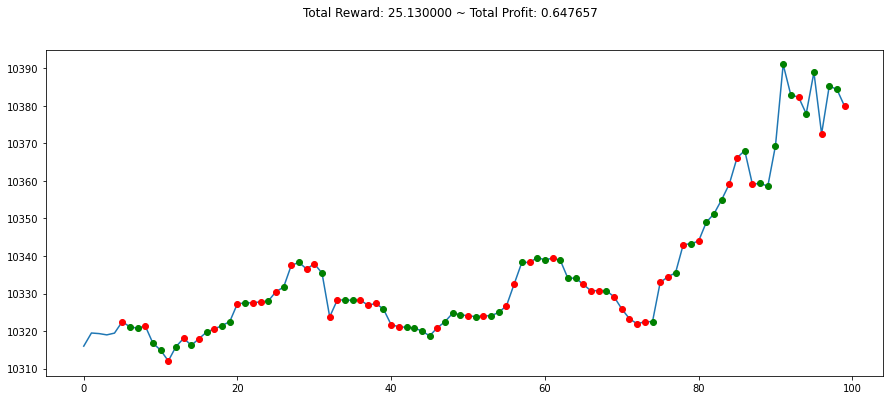

In [11]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [27]:
env_maker = lambda: gym.make('stocks-v1', df=df, frame_bound=(10,500), window_size=100)
env = DummyVecEnv([env_maker])

In [33]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=7000)

Insde LEARN
Totale timesteps: 7000
N bath: 5
Tt/nb: 1401
[0. 0. 0. 0. 0.]
---------------------------------
| explained_variance | nan      |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 0.685    |
| total reward       | 0        |
| total_timesteps    | 5        |
| value_loss         | 0.00118  |
---------------------------------
[0.32990167 0.333234   0.3366     0.34       0.        ]
[4.046147 4.087017 4.1283   4.17     0.      ]
[2.15622 2.178   2.2     0.      0.     ]
[3.7917 3.83   0.     0.     0.    ]
[2.15622 2.178   2.2     0.      0.     ]
[0.32990167 0.333234   0.3366     0.34       0.        ]
[-1.8047562 -1.822986  -1.8414    -1.86       0.       ]
[2.0460696 2.066737  2.087613  2.1087    2.13     ]
[5.910003  5.9697003 6.03      0.        0.       ]
[0. 0. 0. 0. 0.]
[1.7194668 1.7368351 1.7543789 1.7721    1.79     ]
[3.7917 3.83   0.     0.     0.    ]
[0.32990167 0.333234   0.3366     0.34       0.        ]
[2.15622 2.178

KeyboardInterrupt: ignored

In [14]:
env = gym.make('stocks-v1', df=df, frame_bound=(90,110), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

ValueError: ignored

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()